## RQ2: Correlation between hotels and other amenities

Let's look back at our broad question for a moment: What impact do hotels or Airbnb apartments have on cities in Europe? 

Since hotels and airbnb apartments could be considered a proxy for tourism, our broad question can also be paraphrased as “What impact does tourism have on cities in Europe?”

Intuitively, cities that attract many tourists are likely to see a more significant increase in the number of cafes, restaurants and other tourist-relevant services than less popular tourist destinations, since there is a higher demand for them.

Therefore, it would be logical to investigate if there is a correlation between the number of hotels and other short-term rental options and the number of cafes and restaurants in european cities. 

### 2.0: Selection of cities

The first city we decided to look it is London, as to stay consistent with the previous data sets.

However, London is simultaneously a big city and attracts a lot of tourists, hence it represents only one class of european cities.

To fully investigate the effect of hotels, we would need to look at at least representatives of two other classes: 
- a small tourist-attractive city
- a small city that does not known for its tourist attractions. 


_Note: It would be ideal to also analyze a big non tourist-attractive city, however, it proved hard to find a representative of this class._

In order to minimize the cultural, political and geographical differences between the cities, it makes sense to stay in one country, namely England, for the analysis.

As the other two cities, we have selected Bath and St. Albans:
 - Bath is a small city with a population of about 94 thousand people (2021 Census), however it is known by tourists for its Roman-built public baths. 
 - St. Albans is a city of comparable population to Bath, however it is known to be more of a locals-populated city rather than a tourist-attracting one.




| Amenities | Areas|
| --- | --- |
| Cafe | London |
| Restaurant | Bath |
| Car rental | St. Albans |

### 2.1: Loading, merging and cleaning the data

We collected the data needed for the analysis from the [OpenStreetMaps](https://www.openstreetmap.org/) via the [Overpass Api](https://wiki.openstreetmap.org/wiki/Overpass_API).

Since the running time of one Overpass query was approximately 17sec, we extracted the data collection process from this notebook and have stored the collected data in csv files for fast access. 

The details of the data collection can be found *INSERT PATH HERE*, but we want to mention a couple of important points about the process here: 
- The range of years is [2013, 2024], except for St. Albans where early data is missing.
- Yearly counts are calculated as mean of monthly count for each month in a given year. 
- Monthly count is the count at the 1st day of the month.
- We took care of ambiguity in OpenStreetMaps area names by making sure our area filter returns only the location we are interested in (e.g. we took care of filtering out anything named "London" besides the capital of England)

In [221]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

In [222]:
years = range(2013, 2025)
areas = ["London", "St_Albans", "Bath"]
amenities = ["cafe", "restaurant", "car_rental", "hotel"]
dependent_amenities = list(filter(lambda x: x != "hotel", amenities))

In [223]:
amenity_df_dict = {}
area_df_dict = {}

for amenity_index in range(0, len(amenities)):
    amenity = amenities[amenity_index]
    amenity_df = pd.DataFrame(index = years)
    
    for area_index in range(0, len(areas)):
        area = areas[area_index]

        area_amenity_df = pd.read_csv(f'../data/amenities/{area}/{amenity}.csv')
        area_amenity_df.set_index(['year'], inplace=True)

        if (not area in area_df_dict):
            area_df_dict[area] = pd.DataFrame(index = years)
        
        area_df = area_df_dict[area]
        area_df[amenity] = area_amenity_df['count']

        area_amenity_df[area] = area_amenity_df['count']
        area_amenity_df.drop(['area', 'count', 'amenity'], axis=1, inplace=True)
        
        
        amenity_df = amenity_df.merge(area_amenity_df, how='outer', left_index=True, right_index=True)

    amenity_df_dict[amenity] = amenity_df


Now we have our data conveniently merged in both ways: grouped by amenity type and grouped by area.

Amenity counts for St. Albans:

In [224]:

display(area_df_dict['St_Albans'])


,cafe,restaurant,car_rental,hotel
2013,0.000000,0.000000,0.00,0.000000
2014,0.000000,0.000000,0.00,0.000000
2015,0.000000,0.000000,0.00,0.000000
2016,0.000000,0.000000,0.00,0.000000
2017,0.000000,0.000000,0.00,0.000000
2018,0.000000,0.000000,0.00,0.000000
2019,20.416667,26.583333,1.75,5.250000
2020,36.000000,46.000000,3.00,8.083333
2021,35.916667,54.750000,3.00,7.333333
2022,37.666667,61.750000,3.00,6.000000


Immediately we can see that St. Albans values are missing before the year 2019. Since having zeroes for all amenity counts can impact our correlation calculations, we should remove years [2013, 2018] from St. Albans data frame.

In [225]:
area_df_dict['St_Albans'].drop(range(2013,2019), inplace=True, errors='ignore')

In [226]:
for area in areas:
    print(area)
    display(area_df_dict[area])

London


,cafe,restaurant,car_rental,hotel
2013,1519.666667,2132.750000,37.750000,348.833333
2014,1689.333333,2364.666667,38.500000,374.083333
2015,1912.416667,2588.500000,40.833333,397.500000
2016,2113.750000,2804.833333,41.583333,424.083333
2017,2351.416667,3139.666667,45.833333,447.583333
2018,2575.333333,3388.083333,54.083333,435.583333
2019,2818.583333,3727.583333,61.333333,426.916667
2020,3025.333333,4056.500000,70.250000,356.666667
2021,3158.916667,4347.583333,76.916667,313.166667
2022,3317.833333,4554.666667,80.000000,297.333333


St_Albans


,cafe,restaurant,car_rental,hotel
2019,20.416667,26.583333,1.75,5.250000
2020,36.000000,46.000000,3.00,8.083333
2021,35.916667,54.750000,3.00,7.333333
2022,37.666667,61.750000,3.00,6.000000
2023,38.833333,62.000000,4.00,6.000000
2024,42.000000,65.333333,4.00,5.333333


Bath


,cafe,restaurant,car_rental,hotel
2013,28.916667,29.500000,0.000000,1.666667
2014,29.833333,31.916667,0.000000,2.750000
2015,38.416667,38.083333,0.000000,4.416667
2016,60.333333,48.333333,0.416667,6.250000
2017,89.833333,59.416667,2.000000,5.250000
2018,80.166667,52.500000,2.000000,3.916667
2019,83.000000,46.250000,2.000000,3.250000
2020,79.916667,43.500000,2.000000,2.000000
2021,78.166667,45.500000,2.000000,2.000000
2022,79.000000,48.500000,2.000000,2.000000


### 2.2: Visualizations of the data

Now that we have the data cleaned and conveniently merged for analysis, let's take a first look at it by plotting each amenity count per location in one plot.

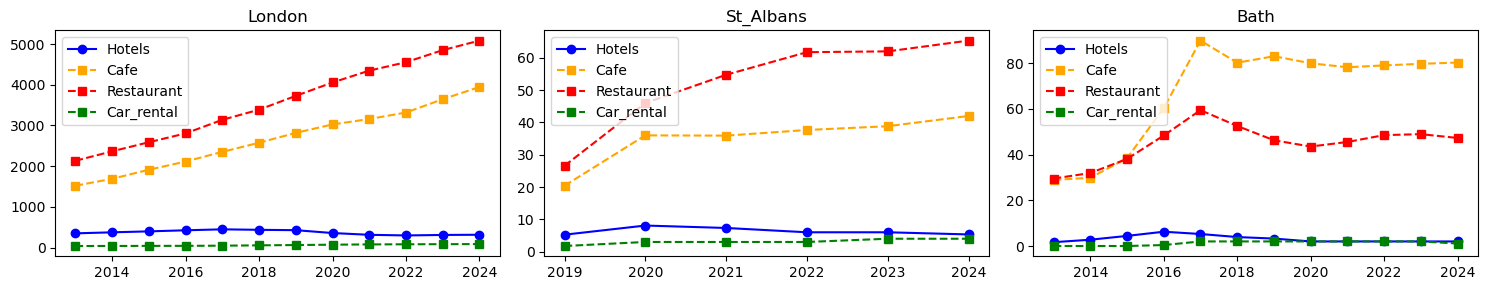

In [227]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

colors = ['orange', 'red', 'green']

for area_index in range(0, len(areas)):
    area = areas[area_index]
    years = area_df_dict[area].index
    x = area_df_dict[area]["hotel"]

    # Plot the hotels line
    ax[area_index].plot(years, x, label='Hotels', marker='o', color='blue')
    
    # Plot the amenity lines
    for amenity_index in range(0, len(dependent_amenities)):
        amenity = dependent_amenities[amenity_index]
        y = area_df_dict[area][amenity]

        ax[area_index].plot(years, y, label=amenity.capitalize(), linestyle='--', marker='s', color=colors[amenity_index])
    

    ax[area_index].set_title(f'{area}')
    ax[area_index].legend()

plt.tight_layout()
plt.show()

Initially, what we can see is that for all three cities the counts of cafes and restaurants seems to be highly correlated, and that the number of car rentals and hotels is significantly lower. 

Due to this discrepancy in the counts scale, it is hard to read the correlation between the number of hotels and other amenities directly from the plot, and another analysis tool should be used for that purpose: scatter matrix and correlation coefficients.


### 2.3: Scatter matrix & Correlation coefficients

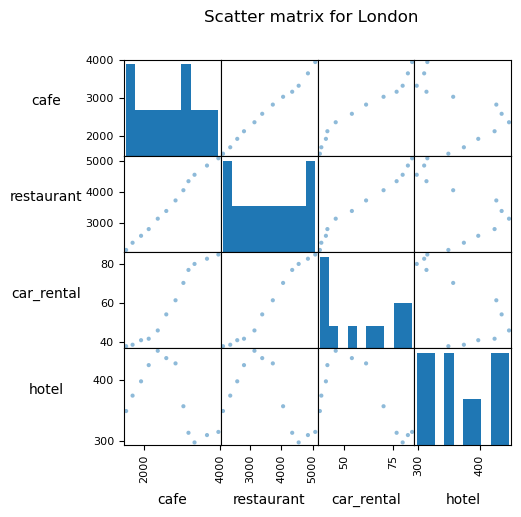

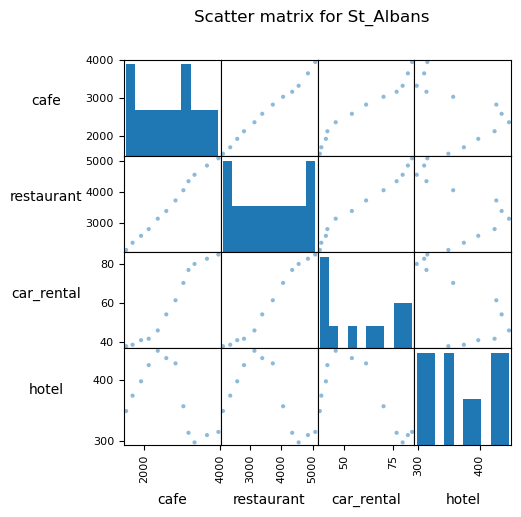

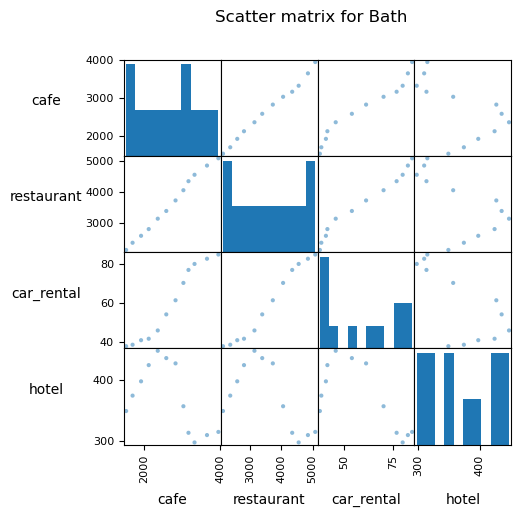

In [228]:
for area in areas:
    sm = pd.plotting.scatter_matrix(area_df_dict['London'], figsize=(5, 5), diagonal='hist')
    plt.suptitle(f'Scatter matrix for {area}')
    [s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
    [s.get_xaxis().set_label_coords(0.5,-0.5) for s in sm.reshape(-1)]
    [s.get_yaxis().set_label_coords(-0.8,0.5) for s in sm.reshape(-1)]



The above scatter matrices confirm very strong positive correlation between the number of cafes and restaurants, however they also highlight string correlation between number of car rentals and number of cafes. The correlation of each dependent amenity with the number of hotels seems weak and rather arbitrary. Let us now confirm it with correlation coefficients:

In [229]:
display(area_df_dict['London'])

,cafe,restaurant,car_rental,hotel
2013,1519.666667,2132.750000,37.750000,348.833333
2014,1689.333333,2364.666667,38.500000,374.083333
2015,1912.416667,2588.500000,40.833333,397.500000
2016,2113.750000,2804.833333,41.583333,424.083333
2017,2351.416667,3139.666667,45.833333,447.583333
2018,2575.333333,3388.083333,54.083333,435.583333
2019,2818.583333,3727.583333,61.333333,426.916667
2020,3025.333333,4056.500000,70.250000,356.666667
2021,3158.916667,4347.583333,76.916667,313.166667
2022,3317.833333,4554.666667,80.000000,297.333333


In [237]:
corr_matrix = np.empty(shape=(len(areas), len(dependent_amenities)))

print('Pearson correlation coefficients:')

for area_index in range(0, len(areas)):
    print()
    for amenity_index in range(0, len(dependent_amenities)):
        area = areas[area_index]
        amenity = dependent_amenities[amenity_index]
        hotel_counts = area_df_dict[area]['hotel']
        amenity_counts = area_df_dict[area][amenity]
        corr_matrix[area_index][amenity_index] = np.corrcoef(hotel_counts, amenity_counts).round(decimals=3)[0][1]
        print(f'{area} (hotels, {amenity}) = {corr_matrix[area_index][amenity_index]}')


Pearson correlation coefficients:

London (hotels, cafe) = -0.559
London (hotels, restaurant) = -0.6
London (hotels, car_rental) = -0.698

St_Albans (hotels, cafe) = 0.217
St_Albans (hotels, restaurant) = -0.002
St_Albans (hotels, car_rental) = 0.004

Bath (hotels, cafe) = 0.008
Bath (hotels, restaurant) = 0.402
Bath (hotels, car_rental) = -0.185
